In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spacy
import matplotlib.pyplot as plt

## Overview

In this notebook the data from each subreddit is cleaned and merged. Then I extract the part of speech frequency for each post and and save the dataframe to a csv.

In [20]:
cst_df = pd.read_csv('../Data/cst_df.csv')
eli5_df = pd.read_csv('../Data/eli5_df.csv')

cst_df.shape, eli5_df.shape

((9985, 3), (9071, 3))

`cst_df` has 214 nulls in the self text column.

In [21]:
cst_df.dropna(inplace=True)

Creating a number of words column will help me remove deleted and short entries.

In [22]:
cst_df['num_words'] = cst_df.selftext.map(lambda txt: len(txt.split(' ')))
eli5_df['num_words'] = eli5_df.selftext.map(lambda txt: len(txt.split(' ')))

cst_df = cst_df.loc[cst_df.num_words > 10]

eli5_df = eli5_df.loc[eli5_df.num_words > 10]

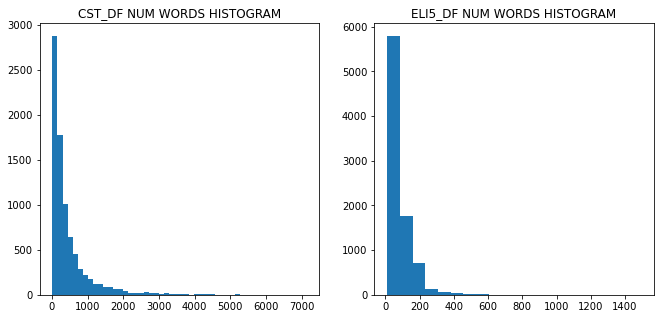

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))

ax[0].hist(cst_df['num_words'], bins = 50)
ax[0].set_title('CST_DF NUM WORDS HISTOGRAM')

ax[1].hist(eli5_df['num_words'], bins = 20)
ax[1].set_title('ELI5_DF NUM WORDS HISTOGRAM');

**Interpretation:** There are a lot more long posts in the CST subreddit. Because I am looking at frequency of part of speech occurrence and not total occurrence I think I will be okay here. Also I am not using the length of a post as a feature in my model so I do not think outliers here will not affect my model significantly.

In [24]:
combined_df = pd.concat([cst_df, eli5_df], ignore_index=True)

combined_df.rename(columns={'selftext': 'text',
                            'created_utc': 'time_posted',
                            'target': 'is_conspiracy'},
                  inplace=True)

combined_df.is_conspiracy = combined_df.is_conspiracy.map({'cst': 1,
                                                           'eli5': 0})

combined_df.reset_index(inplace=True)

I am not interested modeling on post length or time posted for my analysis.

In [18]:
combined_df.drop(columns=['index', 'time_posted', 'num_words'],
                 inplace=True)

In [61]:
nlp = spacy.load('en_core_web_sm')

I want to get what percentage of the post is any particular part of speech. I also create specific columns for question marks and exclamation marks as well. These columns indicate what percent of _all punctuation_ are question marks and exclamation marks. I decided to uppercase the column names to match the spacey formating for parts of speech names.

In [94]:
# https://www.geeksforgeeks.org/how-to-count-the-frequency-of-unique-values-in-numpy-array/

combined_df['QUESTION_MARKS'] = 0
combined_df['EXCLAMATION_MARKS'] = 0

for sub, i in zip(combined_df.text, combined_df.index):
    
    doc = nlp(sub)

    pos_lst, freq_lst = np.unique(np.array([word.pos_
                                            for word in
                                            doc]),
                                  return_counts=True)
# set part of speech column values
    for pos, times_occuring in zip(pos_lst, freq_lst):
        
        if pos in combined_df.columns:
            combined_df.loc[i, pos] = times_occuring/ len(doc)
        else:
            combined_df[pos] = 0
            combined_df.loc[i, pos] = times_occuring/ len(doc)

# set question mark and bang frequency column values            
        if pos == 'PUNCT':
            qmark_count = 0
            bang_count = 0

            for token in doc:
                if token.text == '?':
                    qmark_count += 1

                if token.text == '!':
                    bang_count += 1

# times occuring is the total number of punctuation marks
            combined_df.loc[i, 'QUESTION_MARKS'] = qmark_count/times_occuring
            combined_df.loc[i, 'EXCLAMATION_MARKS'] = bang_count/times_occuring

In [99]:
cst_df.to_csv('../Data/clean_cst_df.csv', index=False)
eli5_df.to_csv('../Data/clean_eli5_df.csv', index=False)
combined_df.to_csv('../Data/master_df.csv', index=False)

## Next Step

Next I fit numerous classification models on this data. The model that performed the best is the random forest classifier. My results and conclusions are in that notebook. All other models are contained in the folder 'other models'